# Multiclass Support Vector Machine exercise

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://vision.stanford.edu/teaching/cs231n/assignments.html) on the course website.*

In this exercise you will:
    
- implement a fully-vectorized **loss function** for the SVM
- implement the fully-vectorized expression for its **analytic gradient**
- **check your implementation** using numerical gradient
- use a validation set to **tune the learning rate and regularization** strength
- **optimize** the loss function with **SGD**
- **visualize** the final learned weights


In [153]:
# Run some setup code for this notebook.
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the
# notebook rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## CIFAR-10 Data Loading and Preprocessing

In [154]:
# Load the raw CIFAR-10 data.
cifar10_dir = 'cs231n/datasets/cifar-10-batches-py'

# Cleaning up variables to prevent loading data multiple times (which may cause memory issue)
try:
   del X_train, y_train
   del X_test, y_test
   print('Clear previously loaded data.')
except:
   pass

X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)

# As a sanity check, we print out the size of the training and test data.
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Clear previously loaded data.
Training data shape:  (50000, 32, 32, 3)
Training labels shape:  (50000,)
Test data shape:  (10000, 32, 32, 3)
Test labels shape:  (10000,)


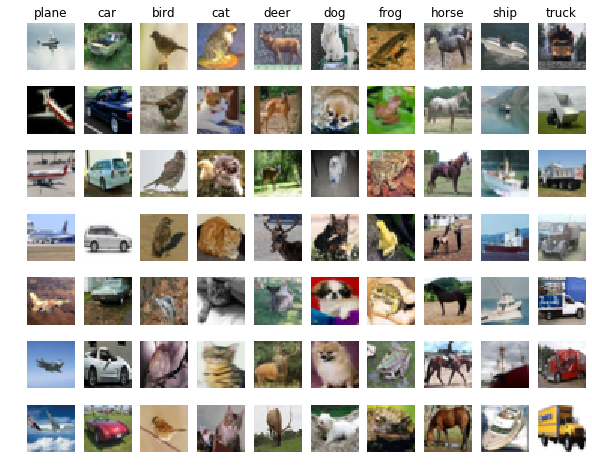

In [155]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y, cls in enumerate(classes):
    idxs = np.flatnonzero(y_train == y)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X_train[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [156]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the training data;
# we can use this for development so our code runs faster.
num_training = 49000
num_validation = 1000
num_test = 1000
num_dev = 500

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X_train[mask]
y_val = y_train[mask]

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X_train[mask]
y_train = y_train[mask]

# We will also make a development set, which is a small subset of
# the training set.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

# We use the first num_test points of the original test set as our
# test set.
mask = range(num_test)
X_test = X_test[mask]
y_test = y_test[mask]

print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)

Train data shape:  (49000, 32, 32, 3)
Train labels shape:  (49000,)
Validation data shape:  (1000, 32, 32, 3)
Validation labels shape:  (1000,)
Test data shape:  (1000, 32, 32, 3)
Test labels shape:  (1000,)


In [157]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (49000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


Averaging the values of all vectors in the training data.
[130.64189796 135.98173469 132.47391837 130.05569388 135.34804082
 131.75402041 130.96055102 136.14328571 132.47636735 131.48467347]


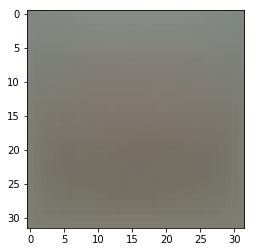

(49000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


In [158]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
print("Averaging the values of all vectors in the training data.")
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

# third: append the bias dimension of ones (i.e. bias trick) so that our SVM
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

## SVM Classifier

Your code for this section will all be written inside **cs231n/classifiers/linear_svm.py**. 

As you can see, we have prefilled the function `compute_loss_naive` which uses for loops to evaluate the multiclass SVM loss function. 

In [159]:
# Evaluate the naive implementation of the loss we provided for you:
from cs231n.classifiers.linear_svm import svm_loss_naive
import time

# generate a random SVM weight matrix of small numbers
W = np.random.randn(3073, 10) * 0.0001 
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.000005)
print(W.shape)
print('loss: %f' % (loss, ))
print(X_dev.shape)


(3073, 10)
loss: 9.351565
(500, 3073)


The `grad` returned from the function above is right now all zero. Derive and implement the gradient for the SVM cost function and implement it inline inside the function `svm_loss_naive`. You will find it helpful to interleave your new code inside the existing function.

To check that you have correctly implemented the gradient correctly, you can numerically estimate the gradient of the loss function and compare the numeric estimate to the gradient that you computed. We have provided code that does this for you:

In [160]:
# Once you've implemented the gradient, recompute it with the code below
# and gradient check it with the function we provided for you

# Compute the loss and its gradient at W.
loss, grad = svm_loss_naive(W, X_dev, y_dev, 0.0)

# Numerically compute the gradient along several randomly chosen dimensions, and
# compare them with your analytically computed gradient. The numbers should match
# almost exactly along all dimensions.
from cs231n.gradient_check import grad_check_sparse
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad)
print("##########")
# do the gradient check once again with regularization turned on
# you didn't forget the regularization gradient did you?
loss, grad = svm_loss_naive(W, X_dev, y_dev, 5e1)
f = lambda w: svm_loss_naive(w, X_dev, y_dev, 5e1)[0]
grad_numerical = grad_check_sparse(f, W, grad)

numerical: 2.488195 analytic: 2.488195, relative error: 1.195018e-10
numerical: 8.682891 analytic: 8.682891, relative error: 2.316310e-11
numerical: 5.036042 analytic: 5.036042, relative error: 9.254431e-11
numerical: 22.878567 analytic: 22.878567, relative error: 8.930634e-12
numerical: 18.276000 analytic: 18.276000, relative error: 5.934214e-12
numerical: 15.131802 analytic: 15.131802, relative error: 8.031863e-12
numerical: -7.134000 analytic: -7.134000, relative error: 4.452632e-11
numerical: -18.215688 analytic: -18.215688, relative error: 1.137303e-11
numerical: -14.581033 analytic: -14.581033, relative error: 2.168561e-11
numerical: -8.187702 analytic: -8.187702, relative error: 1.925599e-11
##########
numerical: -36.703264 analytic: -36.703264, relative error: 5.045566e-12
numerical: 4.340017 analytic: 4.340017, relative error: 9.081875e-11
numerical: -30.181798 analytic: -30.181798, relative error: 5.632505e-12
numerical: -2.475378 analytic: -2.475378, relative error: 3.557463

**Inline Question 1**

It is possible that once in a while a dimension in the gradcheck will not match exactly. What could such a discrepancy be caused by? Is it a reason for concern? What is a simple example in one dimension where a gradient check could fail? How would change the margin affect of the frequency of this happening? *Hint: the SVM loss function is not strictly speaking differentiable*

$\color{blue}{\textit Your Answer:}$ *fill this in.*  


In [161]:
# Next implement the function svm_loss_vectorized; for now only compute the loss;
# we will implement the gradient in a moment.
tic = time.time()
loss_naive, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Naive loss: %e computed in %fs' % (loss_naive, toc - tic))

from cs231n.classifiers.linear_svm import svm_loss_vectorized
tic = time.time()
loss_vectorized, _ = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print('Vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))
# The losses should match but your vectorized implementation should be much faster.
print('difference: %f' % (loss_naive - loss_vectorized))

Naive loss: 9.351565e+00 computed in 0.116062s
The shape of the W matrix: (3073, 10)
The shape of the X matrix is: (500, 3073)
The shape of the vector of the correct scores is: (500, 1)
The shape of the margins vector is: (500, 10)
The shape of the row-wise sum of total number of margins greater than zero is: (500,)
(500,)
Vectorized loss: 9.351565e+00 computed in 0.006709s
difference: -0.000000


In [162]:
# Complete the implementation of svm_loss_vectorized, and compute the gradient
# of the loss function in a vectorized way.

# The naive implementation and the vectorized implementation should match, but
# the vectorized version should still be much faster.
tic = time.time()
loss, grad_naive = svm_loss_naive(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("naive loss",loss)
# print('Naive loss and gradient: computed in %fs' % (toc - tic))

tic = time.time()
loss, grad_vectorized = svm_loss_vectorized(W, X_dev, y_dev, 0.000005)
toc = time.time()
print("vec loss",loss)

# print('Vectorized loss and gradient: computed in %fs' % (toc - tic))

# The loss is a single number, so it is easy to compare the values computed
# by the two implementations. The gradient on the other hand is a matrix, so
# we use the Frobenius norm to compare them.
difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('difference: %f' % difference)

naive loss 9.351565460757328
The shape of the W matrix: (3073, 10)
The shape of the X matrix is: (500, 3073)
The shape of the vector of the correct scores is: (500, 1)
The shape of the margins vector is: (500, 10)
The shape of the row-wise sum of total number of margins greater than zero is: (500,)
(500,)
vec loss 9.35156546075734
difference: 0.000000


### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to do SGD to minimize the loss.

In [207]:
# In the file linear_classifier.py, implement SGD in the function
# LinearClassifier.train() and then run it with the code below.
from cs231n.classifiers import LinearSVM
svm = LinearSVM()
tic = time.time()
loss_hist = svm.train(X_train, y_train, learning_rate=1e-7, reg=2.5e4,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 806.316500
iteration 100 / 1500: loss 471.109956
iteration 200 / 1500: loss 285.569830
iteration 300 / 1500: loss 173.104358
iteration 400 / 1500: loss 104.936093
iteration 500 / 1500: loss 63.616358
iteration 600 / 1500: loss 38.567965
iteration 700 / 1500: loss 23.393154
iteration 800 / 1500: loss 14.190147
iteration 900 / 1500: loss 8.612547
iteration 1000 / 1500: loss 5.234957
iteration 1100 / 1500: loss 3.187437
iteration 1200 / 1500: loss 1.947118
iteration 1300 / 1500: loss 1.192162
iteration 1400 / 1500: loss 0.736410
That took 3.571772s


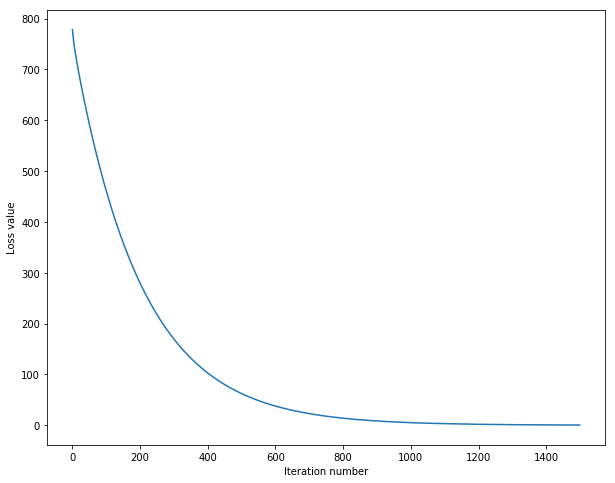

In [182]:
# A useful debugging strategy is to plot the loss as a function of
# iteration number:
plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

In [220]:
# Write the LinearSVM.predict function and evaluate the performance on both the
# training and validation set
def train_val(data,hyperparameters):
    num_iters = 3000
    lr, reg= hyperparameters
    X_train, y_train, X_val, y_val = data
    
    svm = LinearSVM()
    svm.train(X_train, y_train, learning_rate=lr, reg=reg,
                      num_iters=num_iters, verbose=True)
    y_train_pred = svm.predict(X_train)
    y_val_pred = svm.predict(X_val)

    train_accuracy = np.mean(y_train == y_train_pred)
    val_accuracy = np.mean(y_val == y_val_pred)

    print('training accuracy: %f' % (train_accuracy))
    print('validation accuracy: %f' % (val_accuracy))
    return train_accuracy, val_accuracy, svm

In [227]:
# Use the validation set to tune hyperparameters (regularization strength and
# learning rate). You should experiment with different ranges for the learning
# rates and regularization strengths; if you are careful you should be able to
# get a classification accuracy of about 0.39 on the validation set.

#Note: you may see runtime/overflow warnings during hyper-parameter search. 
# This may be caused by extreme values, and is not a bug.

learning_rates = [3e-4,3e-5,3e-6,3e-7,3e-8,6e-8,3e-9,]
regularization_strengths = [5e2,5e3,5e4, 5e5,8e4,1e5,3e5]
lr = np.random.uniform(low=3e-9,high=3e-4,size=(20,))
reg =np.random.uniform(low=3e2,high=3e5,size=(20,))
learning_rates = lr


# results is dictionary mapping tuples of the form
# (learning_rate, regularization_strength) to tuples of the form
# (training_accuracy, validation_accuracy). The accuracy is simply the fraction
# of data points that are correctly classified.
results = {}
best_val = -1   # The highest validation accuracy that we have seen so far.
best_svm = None # The LinearSVM object that achieved the highest validation rate.

################################################################################
# TODO:                                                                        #
# Write code that chooses the best hyperparameters by tuning on the validation #
# set. For each combination of hyperparameters, train a linear SVM on the      #
# training set, compute its accuracy on the training and validation sets, and  #
# store these numbers in the results dictionary. In addition, store the best   #
# validation accuracy in best_val and the LinearSVM object that achieves this  #
# accuracy in best_svm.                                                        #
#                                                                              #
# Hint: You should use a small value for num_iters as you develop your         #
# validation code so that the SVMs don't take much time to train; once you are #
# confident that your validation code works, you should rerun the validation   #
# code with a larger value for num_iters.                                      #
################################################################################
# *****START OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
hyperparameters =[]
print(len(hyperparameters))
for lr in learning_rates:
    for reg in regularization_strengths:
        params = (lr,reg)
        hyperparameters.append(params)

data = [X_train, y_train, X_val, y_val]

for params in hyperparameters:
    train_accuracy, val_accuracy, svm = train_val(data,params)
    
    results[params] = [train_accuracy, val_accuracy]
    if val_accuracy>best_val:
        best_val = val_accuracy
        best_svm = svm
    
    
# *****END OF YOUR CODE (DO NOT DELETE/MODIFY THIS LINE)*****
    
# Print out results.
for lr, reg in sorted(results):
    train_accuracy, val_accuracy = results[(lr, reg)]
    print('lr %e reg %e train accuracy: %f val accuracy: %f' % (
                lr, reg, train_accuracy, val_accuracy))
    
print('best validation accuracy achieved during cross-validation: %f' % best_val)

0
iteration 0 / 3000: loss 38.270124
iteration 100 / 3000: loss 4.635523
iteration 200 / 3000: loss 0.887659
iteration 300 / 3000: loss 0.414269
iteration 400 / 3000: loss 0.117327
iteration 500 / 3000: loss 0.022467
iteration 600 / 3000: loss 0.713833
iteration 700 / 3000: loss 0.136692
iteration 800 / 3000: loss 0.161457
iteration 900 / 3000: loss 0.030917
iteration 1000 / 3000: loss 1.865380
iteration 1100 / 3000: loss 0.357203
iteration 1200 / 3000: loss 0.080152
iteration 1300 / 3000: loss 0.064303
iteration 1400 / 3000: loss 0.025565
iteration 1500 / 3000: loss 0.680646
iteration 1600 / 3000: loss 1.544635
iteration 1700 / 3000: loss 0.115364
iteration 1800 / 3000: loss 1.695441
iteration 1900 / 3000: loss 0.324661
iteration 2000 / 3000: loss 0.062170
iteration 2100 / 3000: loss 0.842394
iteration 2200 / 3000: loss 0.161311
iteration 2300 / 3000: loss 1.013356
iteration 2400 / 3000: loss 0.113622
iteration 2500 / 3000: loss 0.090677
iteration 2600 / 3000: loss 0.218996
iteration 

/Users/juanjo/Desktop/Stanford-CS231n/stanford-cs231n-homeworks/assignment-1/cs231n/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in double_scalars
  loss += np.sum(W*W)*reg
/usr/local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/juanjo/Desktop/Stanford-CS231n/stanford-cs231n-homeworks/assignment-1/cs231n/classifiers/linear_svm.py:96: RuntimeWarning: overflow encountered in multiply
  loss += np.sum(W*W)*reg


iteration 200 / 3000: loss inf
iteration 300 / 3000: loss inf


/Users/juanjo/Desktop/Stanford-CS231n/stanford-cs231n-homeworks/assignment-1/cs231n/classifiers/linear_svm.py:109: RuntimeWarning: overflow encountered in multiply
  dW += W*reg
/Users/juanjo/Desktop/Stanford-CS231n/stanford-cs231n-homeworks/assignment-1/cs231n/classifiers/linear_svm.py:91: RuntimeWarning: invalid value encountered in subtract
  margins = scores - correct_scores + 1
/Users/juanjo/Desktop/Stanford-CS231n/stanford-cs231n-homeworks/assignment-1/cs231n/classifiers/linear_svm.py:92: RuntimeWarning: invalid value encountered in less
  margins[margins<0] = 0
/Users/juanjo/Desktop/Stanford-CS231n/stanford-cs231n-homeworks/assignment-1/cs231n/classifiers/linear_svm.py:98: RuntimeWarning: invalid value encountered in greater
  margins[margins>0]=1


iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 2482.826713
iteration 100 / 3

iteration 500 / 3000: loss inf
iteration 600 / 3000: loss inf
iteration 700 / 3000: loss inf
iteration 800 / 3000: loss inf


/usr/local/lib/python3.7/site-packages/numpy/core/_methods.py:36: RuntimeWarning: overflow encountered in reduce
  return umr_sum(a, axis, dtype, out, keepdims, initial)
/Users/juanjo/Desktop/Stanford-CS231n/stanford-cs231n-homeworks/assignment-1/cs231n/classifiers/linear_svm.py:91: RuntimeWarning: overflow encountered in subtract
  margins = scores - correct_scores + 1


iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 15140.676658
iteration 100 / 3000: loss 710760732455597256679236656161684234912678128850809249382226654694417946278646002040431069794719049939357007415856857973984841469105618082999320

iteration 1200 / 3000: loss 0.517221
iteration 1300 / 3000: loss 54.446014
iteration 1400 / 3000: loss 1.349678
iteration 1500 / 3000: loss 0.327679
iteration 1600 / 3000: loss 19.475164
iteration 1700 / 3000: loss 31.627813
iteration 1800 / 3000: loss 57.430966
iteration 1900 / 3000: loss 22.788705
iteration 2000 / 3000: loss 0.654980
iteration 2100 / 3000: loss 129.374209
iteration 2200 / 3000: loss 656.102703
iteration 2300 / 3000: loss 40.665490
iteration 2400 / 3000: loss 8.756742
iteration 2500 / 3000: loss 903.336155
iteration 2600 / 3000: loss 0.832320
iteration 2700 / 3000: loss 173.974425
iteration 2800 / 3000: loss 312.094013
iteration 2900 / 3000: loss 192.678285
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.153857
validation accuracy: 0.165000
iteration 0 / 3000: loss 1552.974146
iteration 100 / 3000: loss 15218968309241289907555184995343000923596345936879534795778453551606592182225998015902882251931648.000000
iteration 200 / 3000: loss

iteration 1500 / 3000: loss 0.025047
iteration 1600 / 3000: loss 4.847764
iteration 1700 / 3000: loss 16.259735
iteration 1800 / 3000: loss 48.742056
iteration 1900 / 3000: loss 0.129481
iteration 2000 / 3000: loss 0.529757
iteration 2100 / 3000: loss 516.864713
iteration 2200 / 3000: loss 0.325888
iteration 2300 / 3000: loss 12.904064
iteration 2400 / 3000: loss 3.569380
iteration 2500 / 3000: loss 2.525802
iteration 2600 / 3000: loss 91.112140
iteration 2700 / 3000: loss 0.225243
iteration 2800 / 3000: loss 2.123102
iteration 2900 / 3000: loss 77.882157
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.161776
validation accuracy: 0.170000
iteration 0 / 3000: loss 188.976437
iteration 100 / 3000: loss 10188.192527
iteration 200 / 3000: loss 11608.034335
iteration 300 / 3000: loss 9910.923731
iteration 400 / 3000: loss 8664.497141
iteration 500 / 3000: loss 7988.770922
iteration 600 / 3000: loss 11985.441655
iteration 700 / 3000: loss 7941.906666
iterat

iteration 200 / 3000: loss 0.235693
iteration 300 / 3000: loss 1.880210
iteration 400 / 3000: loss 0.164811
iteration 500 / 3000: loss 0.806236
iteration 600 / 3000: loss 0.070671
iteration 700 / 3000: loss 1.476773
iteration 800 / 3000: loss 0.129448
iteration 900 / 3000: loss 0.120795
iteration 1000 / 3000: loss 1.055537
iteration 1100 / 3000: loss 7.827378
iteration 1200 / 3000: loss 0.635744
iteration 1300 / 3000: loss 0.090367
iteration 1400 / 3000: loss 0.577179
iteration 1500 / 3000: loss 0.229356
iteration 1600 / 3000: loss 4.806868
iteration 1700 / 3000: loss 0.421350
iteration 1800 / 3000: loss 0.036934
iteration 1900 / 3000: loss 0.861398
iteration 2000 / 3000: loss 0.846063
iteration 2100 / 3000: loss 23.812781
iteration 2200 / 3000: loss 0.392477
iteration 2300 / 3000: loss 2.498837
iteration 2400 / 3000: loss 0.219037
iteration 2500 / 3000: loss 1.774600
iteration 2600 / 3000: loss 0.155554
iteration 2700 / 3000: loss 1.211275
iteration 2800 / 3000: loss 0.332419
iteratio

iteration 1300 / 3000: loss inf
iteration 1400 / 3000: loss inf
iteration 1500 / 3000: loss inf
iteration 1600 / 3000: loss inf
iteration 1700 / 3000: loss inf
iteration 1800 / 3000: loss inf
iteration 1900 / 3000: loss inf
iteration 2000 / 3000: loss inf
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 9158.057014
iteration 100 / 3000: loss 18614979996595379651005518801991312605723120109322833330224369505892419965291222516574479440307832936308331310057553625397103659116408184622944852483061362880151552.000000
iteration 200 / 3000: loss inf
iteration 300 / 3000: loss inf
iteration 400 / 3000: loss nan
iterati

iteration 100 / 3000: loss 99221088041797280482056491016688648054996882426431725935386572112687216787020327844692573217603860471480394185631507531998341633212414531570411172438162111635839678964215085381070251961218100726386734608185590951839831566757593979944491554455624543629124391951567957096644214784.000000
iteration 200 / 3000: loss inf
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: 

iteration 2300 / 3000: loss 811.014938
iteration 2400 / 3000: loss 1049.387041
iteration 2500 / 3000: loss 810.533671
iteration 2600 / 3000: loss 1078.407291
iteration 2700 / 3000: loss 1135.130507
iteration 2800 / 3000: loss 1107.901740
iteration 2900 / 3000: loss 764.573138
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.143184
validation accuracy: 0.147000
iteration 0 / 3000: loss 3115.410833
iteration 100 / 3000: loss 1470.580196
iteration 200 / 3000: loss 1957.396298
iteration 300 / 3000: loss 1813.219098
iteration 400 / 3000: loss 2239.012267
iteration 500 / 3000: loss 2462.660764
iteration 600 / 3000: loss 1959.460373
iteration 700 / 3000: loss 2340.356725
iteration 800 / 3000: loss 1972.203320
iteration 900 / 3000: loss 2004.919746
iteration 1000 / 3000: loss 1917.789379
iteration 1100 / 3000: loss 2089.755623
iteration 1200 / 3000: loss 2001.491957
iteration 1300 / 3000: loss 2482.951578
iteration 1400 / 3000: loss 2234.285434
iteration 1500 

iteration 200 / 3000: loss inf
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0

iteration 700 / 3000: loss inf
iteration 800 / 3000: loss inf
iteration 900 / 3000: loss inf
iteration 1000 / 3000: loss inf
iteration 1100 / 3000: loss inf
iteration 1200 / 3000: loss inf
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 2469.559296
iteration 100 / 3000: loss 51.101110
iteration 200 / 3000: loss 11.186097
iteration 300 / 3000: loss 13.885290

iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 15340.542360
iteration 100 / 3000: loss inf
iteration 200 / 3000: loss nan
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 30

iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 15296.991374
iteration 100 / 3000: loss inf
iteration 200 / 3000: loss nan
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 30

iteration 800 / 3000: loss 2095.072302
iteration 900 / 3000: loss 1831.971003
iteration 1000 / 3000: loss 1767.494128
iteration 1100 / 3000: loss 1923.911117
iteration 1200 / 3000: loss 1788.914182
iteration 1300 / 3000: loss 1714.021978
iteration 1400 / 3000: loss 1854.862558
iteration 1500 / 3000: loss 2255.943068
iteration 1600 / 3000: loss 1750.311876
iteration 1700 / 3000: loss 1986.690924
iteration 1800 / 3000: loss 1680.701427
iteration 1900 / 3000: loss 2030.919379
iteration 2000 / 3000: loss 1813.272841
iteration 2100 / 3000: loss 1412.611321
iteration 2200 / 3000: loss 2330.996220
iteration 2300 / 3000: loss 1899.053482
iteration 2400 / 3000: loss 2116.931368
iteration 2500 / 3000: loss 1558.697999
iteration 2600 / 3000: loss 1854.788050
iteration 2700 / 3000: loss 2236.253374
iteration 2800 / 3000: loss 2259.010458
iteration 2900 / 3000: loss 1806.999687
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.112061
validation accuracy: 0.127000
it

iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 41.675915
iteration 100 / 3000: loss 0.172101
iteration 200 / 3000: loss 0.671256
iteration 300 / 3000: loss 0.746597
iteration 400 / 3000: loss 1.325119
iteration 500 / 3000: loss 17.162407
iteration 600 / 3000: loss 11.820585
iteration 700 / 3000: loss 12.554578
iteration 800 / 3000: loss 0.682464
iteration 900 / 3000: loss 1.808964
iteration 1000 / 3000: loss 3.824701
iteration 1100 / 3000: loss 3.392001
iteration 1200 / 3000: loss 4.231137
iteration 1300 / 3000: loss 14.552722
iteration 1400 / 3000: loss 3.583168
iteration 1500 / 3000: loss 2.529269
iterati

iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 9409.941115
iteration 100 / 3000: loss 373290364078124984850

iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 3093.262024
iteration 100 / 3000: loss 843780854533230055178863155117294261247445308687424832413055833873368722611882689665540139170957812486655912226958098620316899594126941842889993486071155828815986908157818522727857230528446683835363425299082466614539156693237073483923867677411597478789120.000000
iteration 200 / 3000: loss inf
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 

iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 3064.034574
iteration 100 / 3000: loss 2408575425092276629527980793361595960570311127537291031154911884032457407772124969572098611618711420020463478796751089500637567960277705768681280703351211606885695607430762553208460326779226516485802542172754

iteration 200 / 3000: loss inf
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0

iteration 100 / 3000: loss 14389010125785489127791472843764461264295089295645433571254724011008112835894356986853251566844533074349532651873795207881866174245416773715388310127244586999784733098929651298337610956462487035246038013338694286647857512448.000000
iteration 200 / 3000: loss inf
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 250

iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 2468.721846
iteration 100 / 3000: loss 1406307546732421680792243003372565519832989105462340351519679003932752395746727781448046035383805546003033326803048889551523426153603859415628171633296324366699980787091953054834912215288897157928903858243958771943818981221157421587167907329156836236864134608916583102283776.000000
iteration 200 / 3000: loss inf
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss n

iteration 200 / 3000: loss nan
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 3000: loss nan
iteration 1200 / 3000: loss nan
iteration 1300 / 3000: loss nan
iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0

iteration 1400 / 3000: loss nan
iteration 1500 / 3000: loss nan
iteration 1600 / 3000: loss nan
iteration 1700 / 3000: loss nan
iteration 1800 / 3000: loss nan
iteration 1900 / 3000: loss nan
iteration 2000 / 3000: loss nan
iteration 2100 / 3000: loss nan
iteration 2200 / 3000: loss nan
iteration 2300 / 3000: loss nan
iteration 2400 / 3000: loss nan
iteration 2500 / 3000: loss nan
iteration 2600 / 3000: loss nan
iteration 2700 / 3000: loss nan
iteration 2800 / 3000: loss nan
iteration 2900 / 3000: loss nan
preds (49000, 10)
ypre (49000,)
preds (1000, 10)
ypre (1000,)
training accuracy: 0.100265
validation accuracy: 0.087000
iteration 0 / 3000: loss 15310.848408
iteration 100 / 3000: loss inf
iteration 200 / 3000: loss nan
iteration 300 / 3000: loss nan
iteration 400 / 3000: loss nan
iteration 500 / 3000: loss nan
iteration 600 / 3000: loss nan
iteration 700 / 3000: loss nan
iteration 800 / 3000: loss nan
iteration 900 / 3000: loss nan
iteration 1000 / 3000: loss nan
iteration 1100 / 30

In [ ]:
# Visualize the cross-validation results
import math
x_scatter = [math.log10(x[0]) for x in results]
y_scatter = [math.log10(x[1]) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors, cmap=plt.cm.coolwarm)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')
plt.show()

In [ ]:
# Evaluate the best svm on test set
y_test_pred = best_svm.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('linear SVM on raw pixels final test set accuracy: %f' % test_accuracy)

In [ ]:
# Visualize the learned weights for each class.
# Depending on your choice of learning rate and regularization strength, these may
# or may not be nice to look at.
w = best_svm.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)
w_min, w_max = np.min(w), np.max(w)
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
    plt.subplot(2, 5, i + 1)
      
    # Rescale the weights to be between 0 and 255
    wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
    plt.imshow(wimg.astype('uint8'))
    plt.axis('off')
    plt.title(classes[i])

**Inline question 2**

Describe what your visualized SVM weights look like, and offer a brief explanation for why they look they way that they do.

$\color{blue}{\textit Your Answer:}$ *fill this in*  
